In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
finalized_reviews = pd.read_csv("finalized_reviews.csv")
finalized_reviews.head()

,Unnamed: 0,review_content,Sentiment
0,0,middle school teacher gifted literature value ...,1
1,1,lightning thief admirable kid fantasy,1
2,2,ok,-1
3,3,there resembling spark film,-1
4,4,truly film age darkly comic stuff mistress mis...,1


In [3]:
from sklearn.model_selection import train_test_split
X_data = finalized_reviews[['review_content']]
y_data = finalized_reviews['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = 0.2, 
                                                    random_state=1, 
                                                    stratify = y_data)
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, 
                                                              test_size = 0.2, 
                                                              random_state=1, 
                                                              stratify = y_train)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)
print('Train/Valid/Test sizes:', y_train.shape[0], y_valid.shape[0], y_test.shape[0])

X_train.shape: (36596, 1)
y_train.shape: (36596,)
X_test.shape: (9150, 1)
y_test.shape: (9150,)
Train/Valid/Test sizes: 36596 7320 9150


In [4]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
# vectorize X_train and X_test
train_matrix = vec.fit_transform(X_train['review_content'].values.astype('U'))
test_matrix = vec.transform(X_test['review_content'].values.astype('U'))

In [5]:
X_train = train_matrix
X_test = test_matrix
y_train = y_train.astype('int')
y_test = y_test.astype('int')
# print dimensions
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36596, 32922)
(36596,)
(9150, 32922)
(9150,)


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

%matplotlib inline
import matplotlib.pyplot as plt

## Bagging with Decision Tree

In [7]:
tree = DecisionTreeClassifier(random_state=1, criterion = 'entropy', max_depth = None)
tree.fit(X_train, y_train)
print(f"Train Accuracy: {tree.score(X_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {tree.score(X_test, y_test)*100:0.3f}%")

Train Accuracy: 99.978%
Test Accuracy: 75.672%


In [8]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=100,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)
bag.fit(X_train, y_train)
print(f"Train Accuracy: {bag.score(X_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {bag.score(X_test, y_test)*100:0.3f}%")

Train Accuracy: 99.973%
Test Accuracy: 80.448%


In [12]:
bag.fit(X_train, y_train)
acc_test_na = bag.score(X_test, y_test)
ci_test_na = 1.96 * np.sqrt((acc_test_na*(1-acc_test_na)) / y_test.shape[0])

test_na_lower = acc_test_na-ci_test_na
test_na_upper = acc_test_na+ci_test_na

print(test_na_lower, test_na_upper)

0.796354477798784 0.8126072708350959


# Plots

In [16]:
from tqdm import tqdm

In [ ]:
pred_train, pred_test = [], []

intervals = np.arange(500, X_train.shape[0] + 1, 1000)

for i in tqdm(intervals):
    bag.fit(X_train[:i], y_train[:i])
    p_train = bag.score(X_train[:i], y_train[:i])
    p_test = bag.score(X_test, y_test)
    pred_train.append(p_train)
    pred_test.append(p_test)

 22%|██▏       | 8/37 [07:15<38:57, 80.60s/it]

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train.shape[0] + X_test.shape[0]])
    plt.axvspan(X_train.shape[0], 
                X_train.shape[0] + X_test.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.6, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    #plt.savefig('figures/model-eval-mnist_0.svg')

# Bootstrap Methods

## OOB Bootstrap with Percentile Method

In [13]:
from mlxtend.evaluate import bootstrap_point632_score
bootstrap_scores = bootstrap_point632_score(bag, 
                                            X_train, y_train, 
                                            n_splits=200, 
                                            method='oob',
                                            random_seed=1)

bootstrap_oob_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_oob_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_oob_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_oob_percentile_upper = np.percentile(bootstrap_scores, 97.5)

print(bootstrap_oob_percentile_lower, bootstrap_oob_percentile_upper)

KeyboardInterrupt: 

## .632 Bootstrap for Bagging with DecisionTree

In [ ]:
from mlxtend.evaluate import bootstrap_point632_score
bootstrap_scores = bootstrap_point632_score(bag, 
                                            X_train, y_train, 
                                            n_splits=200,
                                            random_seed=1)

bootstrap_632_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_632_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_632_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_632_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_632_percentile_lower, bootstrap_632_percentile_upper)

# Plot the Confidence Intervals

In [ ]:
labels = [
    "Normal approx. sample CI (test set, no bootstrap)",
    "Bootstrap, percentile method",
    ".632 Bootstrap, percentile method"
]

mean = [
    acc_test_na,
    bootstrap_oob_mean,
    bootstrap_632_mean
]

lower_error = [
    test_na_lower,
    bootstrap_oob_percentile_lower,
    bootstrap_632_percentile_lower
]

upper_error = [
    test_na_upper,
    bootstrap_oob_percentile_upper,
    bootstrap_632_percentile_upper
]


asymmetric_error = [np.array(mean) - np.array(lower_error), 
                    np.array(upper_error) - np.array(mean)]


fig, ax = plt.subplots(figsize=(8, 2))
ax.errorbar(mean, np.arange(len(mean)), xerr=asymmetric_error, fmt='o')
#ax.set_xlim([0.86, 1.0])
ax.set_yticks(np.arange(len(mean)))
ax.set_yticklabels(labels)
ax.set_xlabel('Prediction Accuracy')
ax.set_title('95% confidence intervals')
plt.tight_layout()
plt.savefig('CI_mnist.pdf')
plt.show()

# Confusion Matrix

[[1428 1192]
 [ 597 5933]]


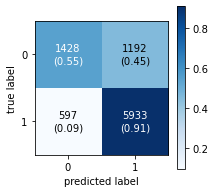

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pipe = make_pipeline(StandardScaler(with_mean=False), 
                     bag)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

fig, ax = plot_confusion_matrix(conf_mat=confmat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(3, 3))
plt.show()